In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import the necessary packages
from pathlib import Path
from PIL import Image
import pickle
import cv2
from google.colab.patches import cv2_imshow

# Import the libraries
import matplotlib.pyplot as plt
import os

In [3]:
test_path = '/content/drive/MyDrive/DIP/test/'
test_report_path = '/content/drive/MyDrive/DIP/testRaporaEklenecek/'
train_path = '/content/drive/MyDrive/DIP/train/'  
save_path = '/content/drive/MyDrive/DIP/histograms/' 

In [4]:
uniform_table = \
    [  
        0,1,2,3,4,58,5,6,7,58,58,58,8,58,9,10,11,58,58,58,58,58,58,58,12,58,58,58,13,58,
        14,15,16,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,17,58,58,58,58,58,58,58,18,
        58,58,58,19,58,20,21,22,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,
        58,58,58,58,58,58,58,58,58,58,58,58,23,58,58,58,58,58,58,58,58,58,58,58,58,58,
        58,58,24,58,58,58,58,58,58,58,25,58,58,58,26,58,27,28,29,30,58,31,58,58,58,32,58,
        58,58,58,58,58,58,33,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,34,58,58,58,58,
        58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,
        58,35,36,37,58,38,58,58,58,39,58,58,58,58,58,58,58,40,58,58,58,58,58,58,58,58,58,
        58,58,58,58,58,58,41,42,43,58,44,58,58,58,45,58,58,58,58,58,58,58,46,47,48,58,49,
        58,58,58,50,51,52,58,53,54,55,56,57
    ];

In [5]:
class helper_functions:
    def __init__(self):
        return
        
    def read_image(self, img_path): 
        return cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2YCR_CB)[:,:,0]
    
    def read_original_image(self, img_path): 
        return cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    def show_img(self, img_path):
        img = cv2.imread(img_path)
        cv2_imshow(img)

    def get_pixel(self, img, center, x, y):
        new_value = 0
        try:
            if img[x][y] >= center:
                new_value = 1
        except:
            pass
        return new_value

    def calc_lbp(self, img, x, y):
         
        center = img[x][y]
        val_ar = []
        val_ar.append(self.get_pixel(img, center, x-1, y-1))     # top_left
        val_ar.append(self.get_pixel(img, center, x-1, y))       # top
        val_ar.append(self.get_pixel(img, center, x-1, y+1))     # top_right
        val_ar.append(self.get_pixel(img, center, x, y+1))       # right
        val_ar.append(self.get_pixel(img, center, x+1, y-1))     # bottom_left
        val_ar.append(self.get_pixel(img, center, x+1, y))       # bottom
        val_ar.append(self.get_pixel(img, center, x+1, y+1))     # bottom_right
        val_ar.append(self.get_pixel(img, center, x, y-1))       # left

        
        #####################
        #   1  |  2  |  4   #
        # ----------------- #
        #  128 |  0  |  8   #
        # ----------------- #
        #   64 |  32 |  16  #
        ##################### -> https://www.researchgate.net/publication/305152373_Texture_Feature_Extraction_by_Using_Local_Binary_Pattern/figures

        power_val = [1, 2, 4, 8, 16, 32, 64, 128]
        LBP = 0
        for i in range(len(val_ar)):
            LBP += val_ar[i] * power_val[i]
        return LBP  

    def flatten(self, l):
        return [item for sublist in l for item in sublist]


    def uniform_lbp_array(self, image, uniform):
        for i in range(len(image)):
            for j in range(len(image[0])):
                image[i][j] = uniform[image[i][j]]
        #print(image)
        return self.flatten(image)


    def hist(self, lbp):
        histogram = [0]*59
        
        for e in range(len(lbp)):
            histogram[lbp[e]] = histogram[lbp[e]] + 1
        
        for e in range(59):
            histogram[e] /= len(lbp)
            
        return histogram

    def manhattan_dist(self, a, b):
        return sum(abs(val1-val2) for val1, val2 in zip(a,b))


    def get_three_min(self, manhattan_arr, n):
        
        firstmin = secmin = thirdmin = 99999
        first = second = third = 0
    
        for idx in range(n):
            # Check if current element
            # is less than firstmin,
            # then update first,second
            # and third
            if manhattan_arr[idx] < firstmin:
                thirdmin = secmin
                secmin = firstmin
                firstmin = manhattan_arr[idx]
                first = idx
    
            # Check if current element is
            # less than secmin then update
            # second and third
            elif manhattan_arr[idx] < secmin:
                thirdmin = secmin
                secmin = manhattan_arr[idx]
                second = idx
    
            # Check if current element is
            # less than,then update third
            elif manhattan_arr[idx] < thirdmin:
                thirdmin = manhattan_arr[idx]
                third = idx

            result_dict = dict({first:firstmin, second:secmin, third:thirdmin})

        return result_dict

    def get_best_matches(self, train, result_dict, train_path):
        # create plots
        plt.subplots(figsize=(12,4))       
        
        print(f"\n---- BEST THREE MATCHES ----:\n")
        keys = list(train.keys())
        i = 0; img_list = img_titles = []
        for key, value in result_dict.items():
            img = keys[key]
            class_ = img.split('_')
            print(f'--> {i+1}. {img} : {value}')
            
            plt.subplot(1,3,i+1)
            plt.title(f'{class_[0]} : {value}')
            plt.imshow(self.read_original_image(train_path + class_[0] + '/' + img))
        
            i = i+1
        print("\n")
        plt.show()
            

    def calculate_best_matches(self, train_dict, test_dict, test_path):
        MAX = 99999
        for test_key, test_value in test_dict.items():
            first = second = third = MAX
            manhattan_array = []
            for train_key, train_value in train_dict.items():
                manhattan_array.append(self.manhattan_dist(test_value, train_value))

            result_dict = self.get_three_min(manhattan_array, len(manhattan_array))
            
            plt.figure(figsize=(4,4))
            plt.title(f"Test Image : {test_key}") 
            plt.imshow(self.read_original_image(test_path + test_key))
            plt.show()
            print("\n")

            self.get_best_matches(train_dict, result_dict, train_path)
            print("\n___________________________________________\n\n\n")


    # def hist(lbp):
#     n_bins = int(lbp.max() + 1)
#     counts, _, bars = plt.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.3')
#     return counts


---------

In [6]:
class train:
    def __init__(self, dataset, training_path):
        self.training_path = training_path
        self.dataset = dataset
 
    def train(self):

        helper = helper_functions()
        img_names = []
        histograms = []
        
        if self.dataset == "train":
            class_list = [path for path in os.listdir(self.training_path) if os.path.isdir(os.path.join(self.training_path, path))]
            
            for one_class in class_list:
                class_path = self.training_path + one_class + "/"
                
                img_files = [path for path in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, path))] 
                
                for img_file in img_files:
                    img_path = class_path + img_file
                    
                    img = helper.read_image(img_path)
                    rows, cols = len(img), len(img[0])
                    lbp = [([0]*cols) for i in range(rows)]
                    for i in range(0, rows):
                        for j in range(0, cols):
                            lbp[i][j] = helper.calc_lbp(img, i, j)
                    lbp_uniformed = helper.uniform_lbp_array(lbp, uniform_table)
                    #print(lbp_uniformed)
                    histogram = helper.hist(lbp_uniformed)
                    
                    img_names.append(img_file)
                    histograms.append(histogram)
                                        
            return dict(zip(img_names, histograms))

        elif self.dataset == "test" or self.dataset == "test_for_report":

            img_files = [path for path in os.listdir(self.training_path) if os.path.isfile(os.path.join(self.training_path, path))] 

            for img_file in img_files:
                img_path = self.training_path + img_file
                
                img = helper.read_image(img_path)

                rows, cols = len(img), len(img[0])
                lbp = [([0]*cols) for i in range(rows)]
                for i in range(0, rows):
                    for j in range(0, cols):
                        lbp[i][j] = helper.calc_lbp(img, i, j)

                lbp_uniformed = helper.uniform_lbp_array(lbp, uniform_table)
                histogram = helper.hist(lbp_uniformed)
                
                img_names.append(img_file)
                histograms.append(histogram)
                        
            return dict(zip(img_names, histograms))

        else:
            print("Wrong dataset")

    
    def save_dictionary(self, dictionary, save_path):
        with open(f'{save_path}{self.dataset}.pkl', 'wb') as f:
            pickle.dump(dictionary, f)

    def get_dictionary(self, save_path):
        with open(f'{save_path}{self.dataset}.pkl', 'rb') as f:
            return pickle.load(f)


In [7]:
train_data = train("train", train_path)
test_data = train("test", test_path)
test_report = train("test_for_report", test_report_path)

In [ ]:
train_dict = train_data.train()

In [ ]:
train_dict = dict( sorted(train_dict.items(), key=lambda x: x[0].lower()) )
train_data.save_dictionary(train_dict, save_path)

In [ ]:
test_dict = test_data.train()

In [ ]:
test_dict = dict( sorted(test_dict.items(), key=lambda x: x[0].lower()) )
test_data.save_dictionary(test_dict, save_path)

In [ ]:
test_report_dict = test_report.train()

In [ ]:
test_report_dict = dict( sorted(test_report_dict.items(), key=lambda x: x[0].lower()) )
test_report.save_dictionary(test_report_dict, save_path)

In [ ]:
helper = helper_functions()
helper.calculate_best_matches(train_dict, test_dict, test_path)

In [ ]:
helper.calculate_best_matches(train_dict, test_report_dict, test_report_path)

In [ ]:
#### LOAD SAVED DICTS ####

In [10]:
train_dict = train_data.get_dictionary(save_path)
test_dict = test_data.get_dictionary(save_path)
test_report_dict = test_report.get_dictionary(save_path)
helper = helper_functions()

In [ ]:
helper.calculate_best_matches(train_dict, test_dict, test_path)

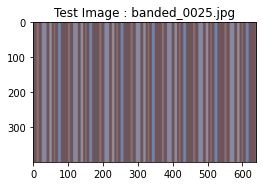




---- BEST THREE MATCHES ----:

--> 1. banded_0006.jpg : 0.14287482638888893
--> 2. banded_0002.jpg : 0.2923828125
--> 3. banded_0012.jpg : 0.3125




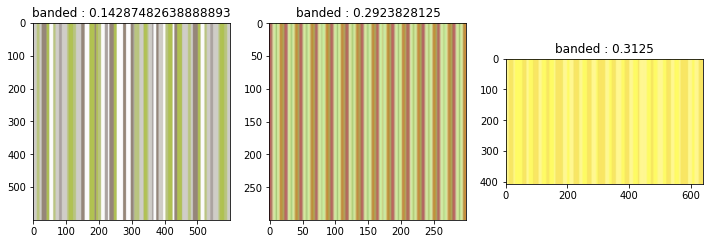


___________________________________________





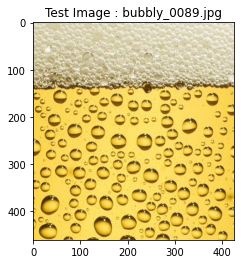




---- BEST THREE MATCHES ----:

--> 1. bubbly_0052.jpg : 0.1066156147383357
--> 2. bubbly_0061.jpg : 0.12036321707743694
--> 3. zigzagged_0045.jpg : 0.14680152026811993




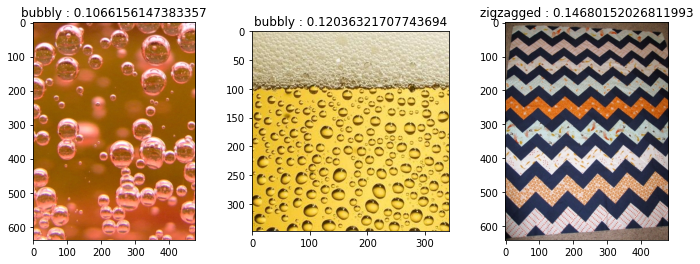


___________________________________________





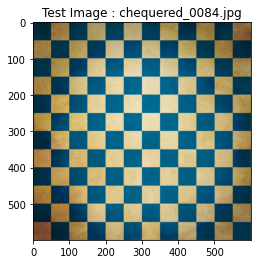




---- BEST THREE MATCHES ----:

--> 1. dotted_0182.jpg : 0.13629624485596709
--> 2. cobwebbed_0047.jpg : 0.17897100192678234
--> 3. zigzagged_0045.jpg : 0.1806180555555556




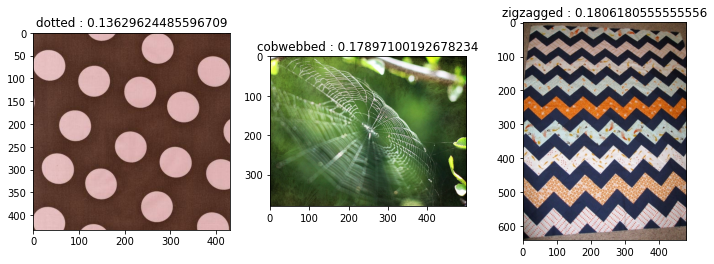


___________________________________________





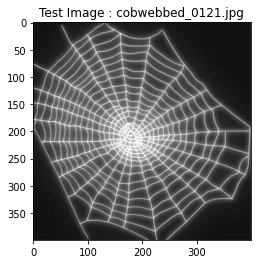




---- BEST THREE MATCHES ----:

--> 1. cobwebbed_0049.jpg : 0.1810348958333334
--> 2. dotted_0184.jpg : 0.18171585365853662
--> 3. bubbly_0066.jpg : 0.18894999999999998




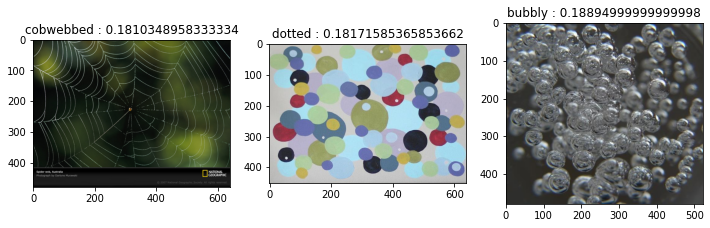


___________________________________________





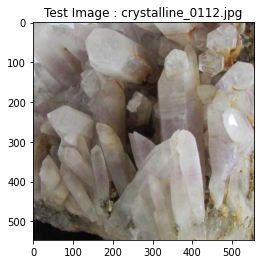




---- BEST THREE MATCHES ----:

--> 1. striped_0098.jpg : 0.07615231823166262
--> 2. crystalline_0213.jpg : 0.09684398497364143
--> 3. striped_0094.jpg : 0.14021047533403933




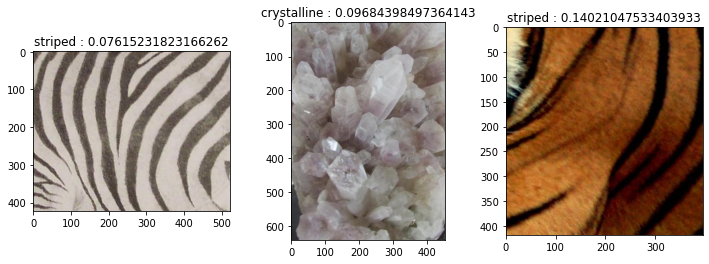


___________________________________________





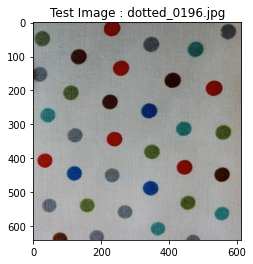




---- BEST THREE MATCHES ----:

--> 1. dotted_0196.jpg : 0.0
--> 2. cobwebbed_0040.jpg : 0.16678429298164435
--> 3. dotted_0183.jpg : 0.2501773630628389




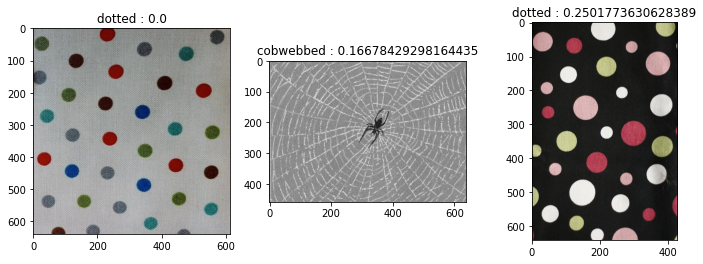


___________________________________________





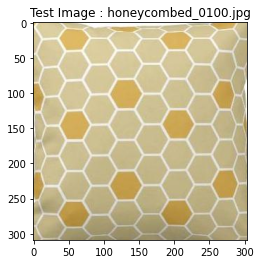




---- BEST THREE MATCHES ----:

--> 1. dotted_0184.jpg : 0.14744004244433448
--> 2. honeycombed_0118.jpg : 0.2009803159227745
--> 3. cobwebbed_0041.jpg : 0.20373321663153626




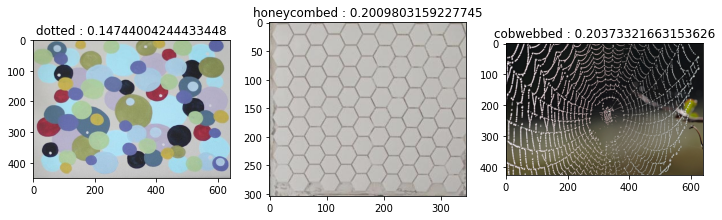


___________________________________________





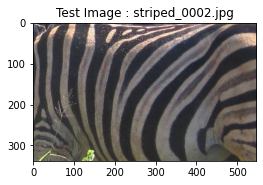




---- BEST THREE MATCHES ----:

--> 1. striped_0098.jpg : 0.11473672511657276
--> 2. crystalline_0208.jpg : 0.14084985800694666
--> 3. honeycombed_0112.jpg : 0.14171813721378693




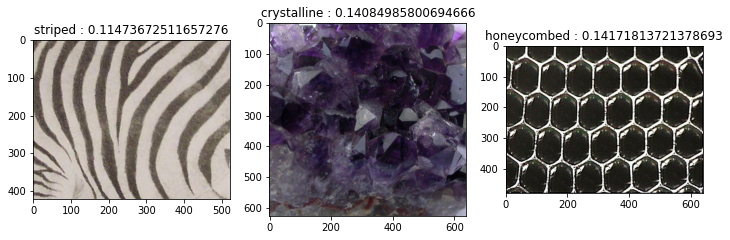


___________________________________________





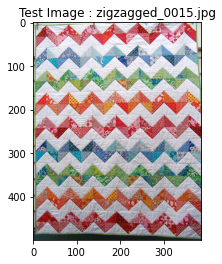




---- BEST THREE MATCHES ----:

--> 1. zigzagged_0010.jpg : 0.1541272144702842
--> 2. cobwebbed_0051.jpg : 0.17456058751529996
--> 3. cobwebbed_0030.jpg : 0.17742798020227113




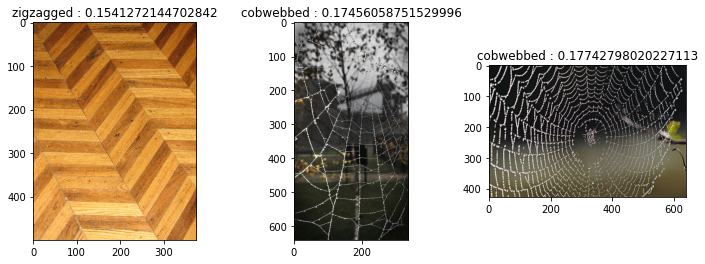


___________________________________________





In [11]:
helper.calculate_best_matches(train_dict, test_report_dict, test_report_path)